# Deep Q-learning

Recall: state value given by the expectation $V_{\pi}(s) = \sum_i w_i R_i$, where $w_i$ are weights and
$R_i$ are rewards. In general, the weights should discount future rewards compared to
recent ones. Similarly, the action-value function $Q_\pi(s,a)$ takes a state and an
action as inputs and returns the value of taking that action given that state. A
Q-function can be represented by a _Q-table_, a table where each cell corresponds to a state-action pair value.

Notice that when we have an optimal Q-function, we have an optimal policy since we know
the best action to take at each state: $\pi(s) = \argmax_a Q(s,a)$.

The problem is that to calculate EACH value of a state or a state-action pair, we need
to sum all the rewards an agent can get if it starts at that state. The **Bellmann
Equation** simplifies the calculation of the value function ($\gamma$ is
the _discount factor_):

$$v_\pi(s_t) = \mathbb{E}_\pi[R_{t+1} + \gamma v_\pi(s_{t+1})]$$

**Q-learning**: algorithm that learns to predict the value of a
state-action pair (Q-function); the prediction is compared to the observed accumulated rewards at
some later time to update the parameters of the algorithm. 

Based on the Bellmann equation, Q-learning algorithms use the update rule ($\alpha$ is
the _learning rate_)

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha[R_{t+1}+ \gamma \max Q(s_{t+1},a)-Q(s_t,a_t)] $$

i.e., the Q_value at time $t$ is updated to be the current predicted $Q$ value plus the
(discounted) amount of value we expect in the future (state $s_{t+1}$), given that we
play optimally from our current state. Here $R_{t+1}$ is the observed reward
corresponding to the action $a_t$.

<figure>
    <img src="Qlearning_algo.png" alt="Caption" width="800" />
    <figcaption>Q-learning algorithm (taken from huggingface.co).</figcaption>
</figure>

## Gridworld

In [1]:
from Gridworld import Gridworld
import numpy as np
import jax.numpy as jnp
import random
from matplotlib import pylab as plt
from flax import nnx
import optax
# static = start from predetermined configuration (for player and objects)
# player = just the player is initialized at random location
# random = both player and objects are randomly placed
game = Gridworld(size=4, mode='static')

In [95]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [96]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [97]:
# every non-winning move receives -1 reward; +10 for winning move; -10 for losing
game.reward()

-1

In [98]:
# show representation of the state: the 4x4 matrices encode the positions of the player
# (P), the goal (+), the pit (-), and the wall (W).
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [2]:
class Model(nnx.Module):
  def __init__(self, l1, l2, l3, l4, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)
    self.linear3 = nnx.Linear(l3, l4, rngs=rngs)

  def __call__(self, x):
    y = nnx.relu(self.linear1(x))
    y = nnx.relu(self.linear2(y))
    y = self.linear3(y)
    return y

l1 = 64
l2 = 150
l3 = 100
l4 = 4

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
model = Model(l1, l2, l3, l4, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
loss_fn = optax.losses.squared_error

In [101]:
def _train_epoch(model, optimizer, state, game):
    def loss(model, state):
        qval = model(state)
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = int(np.argmax(qval))
        
        action = action_set[action_]
        game.makeMove(action)
        state2 = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        reward = game.reward()
        newQ = model(state2.reshape(1,64))
        maxQ = np.max(newQ)
        if reward == -1: #N
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = jnp.asarray([Y])
        X = jnp.array([qval.squeeze()[action_]]) #O
        return optax.losses.squared_error(X, Y).mean(), (reward, state2)

    # update network weights based on MSE between predicted and actual rewards 
    loss_and_aux, grads = nnx.value_and_grad(loss, has_aux=True)(model, state)
    optimizer.update(grads)
    loss, aux = loss_and_aux
    reward, state2 = aux

    return loss, reward, state2

In [102]:
games = 1000
losses = [] #A
for i in range(games): #B
    game = Gridworld(size=4, mode='static')
    # add some noise to the initial state (because most of the state elements are 0,
    # potential problem with ReLU activations)
    state1 = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    status = 1 #F
    while(status == 1): #G
        loss, reward, state1 = _train_epoch(model, optimizer, state1, game)
        losses.append(loss.item())
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/games)

Text(0, 0.5, 'Loss')

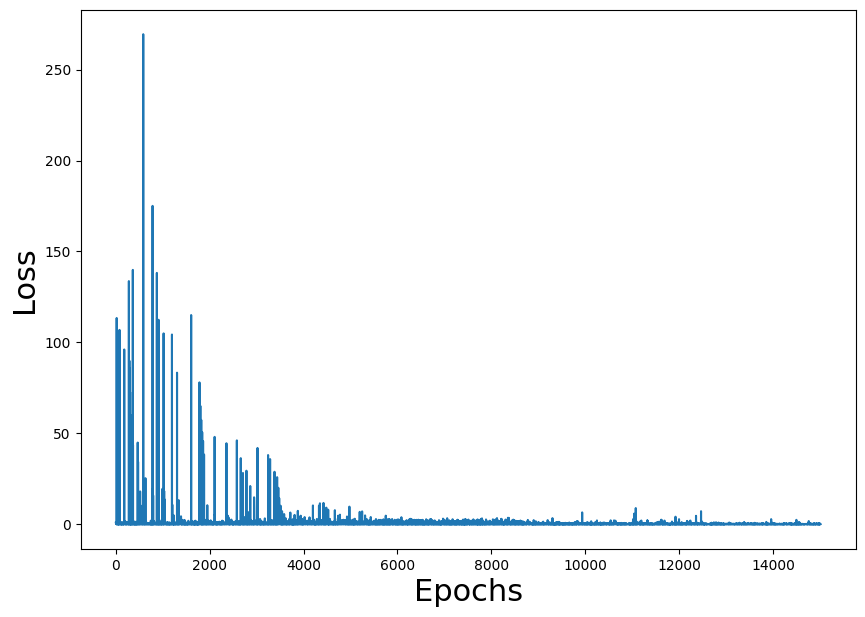

In [103]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [16]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        action_ = int(np.argmax(qval))
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [92]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [93]:
test_model(model, 'random')

Initial State:
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 [' ' 'P' ' ' '+']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 3; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 4; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 5; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 6; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 7; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']
 ['P' ' ' ' ' '+']]
Move #: 8; Taking action: l
[[' ' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [

False

## Experience replay

In [51]:
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))

    def size(self):
        return len(self.buffer)

In [52]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [53]:
class Model(nnx.Module):
  def __init__(self, l1, l2, l3, l4, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(l1, l2, rngs=rngs)
    self.linear2 = nnx.Linear(l2, l3, rngs=rngs)
    self.linear3 = nnx.Linear(l3, l4, rngs=rngs)

  def __call__(self, x):
    y = nnx.relu(self.linear1(x))
    y = nnx.relu(self.linear2(y))
    y = self.linear3(y)
    return y

l1 = 64
l2 = 150
l3 = 100
l4 = 4

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
model = Model(l1, l2, l3, l4, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
loss_fn = optax.losses.squared_error

In [54]:
replay_buffer_size = 1000
batch_size = 200
games = 5000 
epsilon = 0.3
gamma = 0.9
losses = []
total_rewards = []
max_moves = 50

In [55]:
@nnx.jit
def loss_fn(model, states, td_target, actions):
    q_values = model(states)
    q_value = jnp.take_along_axis(q_values, actions[:, None, None], axis=2)[:,:,0]
    loss = optax.losses.squared_error(q_value, td_target).mean()
    return loss

In [56]:
@nnx.jit
def q_learning_update(model, states, actions, rewards, next_states, dones, optimizer):
    target_q_values = model(next_states)
    max_target_q_values = jnp.max(target_q_values, axis=2)

    td_target = rewards.reshape(-1,1) + gamma * max_target_q_values * (1 - dones.reshape(-1,1))

    loss, gradients = nnx.value_and_grad(loss_fn)(model, states, td_target, actions)
    optimizer.update(gradients)
    
    return loss

In [57]:
def train():
    replay_buffer = ReplayBuffer(replay_buffer_size)

    for i in range(games):
        game = Gridworld(size=4, mode='random')
        state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        mov = 0
        done = False
        total_reward = 0

        while not done:
            # select an action using the epsilon-greedy strategy
            if (random.random() < epsilon):
                action_ = np.random.randint(0,4)
            else:
                qval = model(state)
                action_ = int(np.argmax(qval))
            
            action = action_set[action_]
            game.makeMove(action)
            next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
            reward = game.reward()
            done = True if reward > 0 else False

            replay_buffer.add((state, action_, reward, next_state, done))

            if replay_buffer.size() >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = batch
                loss = q_learning_update(model, states, actions, rewards, next_states, dones, optimizer)
                losses.append(loss)

            state = next_state
            total_reward += reward

            if reward != -1 or mov > max_moves:
                done = True
                mov = 0

        total_rewards.append(total_reward)

        print(f"Game: {i}, Total Reward: {total_reward}")

In [58]:
train()

Game: 0, Total Reward: 10
Game: 1, Total Reward: -18
Game: 2, Total Reward: 8
Game: 3, Total Reward: -64
Game: 4, Total Reward: -12
Game: 5, Total Reward: -11
Game: 6, Total Reward: -11
Game: 7, Total Reward: -39
Game: 8, Total Reward: -50
Game: 9, Total Reward: 5
Game: 10, Total Reward: -10
Game: 11, Total Reward: -13
Game: 12, Total Reward: -10
Game: 13, Total Reward: 8
Game: 14, Total Reward: -76
Game: 15, Total Reward: -78
Game: 16, Total Reward: -28
Game: 17, Total Reward: -28
Game: 18, Total Reward: 6
Game: 19, Total Reward: -40
Game: 20, Total Reward: 9
Game: 21, Total Reward: -10
Game: 22, Total Reward: -131
Game: 23, Total Reward: 3
Game: 24, Total Reward: 7
Game: 25, Total Reward: -38
Game: 26, Total Reward: 10
Game: 27, Total Reward: -16
Game: 28, Total Reward: -19
Game: 29, Total Reward: -14
Game: 30, Total Reward: -13
Game: 31, Total Reward: -23
Game: 32, Total Reward: -29
Game: 33, Total Reward: -28
Game: 34, Total Reward: 7
Game: 35, Total Reward: -10
Game: 36, Total Rew

In [59]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y


In [60]:
losses = np.array(losses)
total_rewards = np.array(total_rewards)

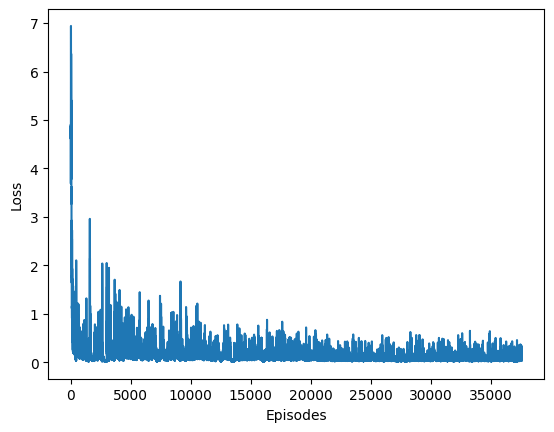

In [61]:
plt.plot(losses)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.show()

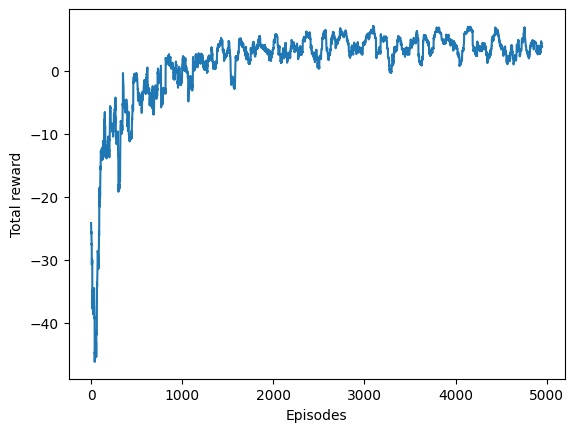

In [62]:
plt.plot(running_mean(total_rewards))
plt.xlabel("Episodes")
plt.ylabel("Total reward")
plt.show()

In [63]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['W' '+' '-' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' 'P' ' ' ' ']
 ['W' '+' '-' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' '+' '-' ' ']]
Game won! Reward: 10


True

In [64]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 914
Win percentage: 91.4%
